# Example: Effect of wavefront aberrations in atom interferometry

As an example, we reproduce two plots from the paper https://link.springer.com/article/10.1007/s00340-015-6138-5.

The simulation will require the following objects and parameters
* `Wavefront`: contains the wavefront aberrations of the interferometry lasers
* `AtomicEnsemble`: an ensemble of atoms which different trajectories or phase space vectors
* `Detector`: determines which atoms contribute to the signal
* times of the three interferometer pulses
* effective wavevector

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

### Loading and preparing wavefront data

Wavefront aberration in multiples of $\lambda$ = 780 nm. 

Load Zernike coefficients from file:

(<Figure size 640x480 with 2 Axes>, <PolarAxes: >)

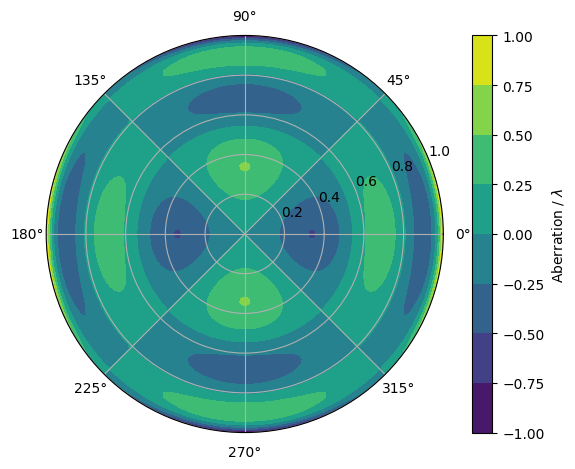

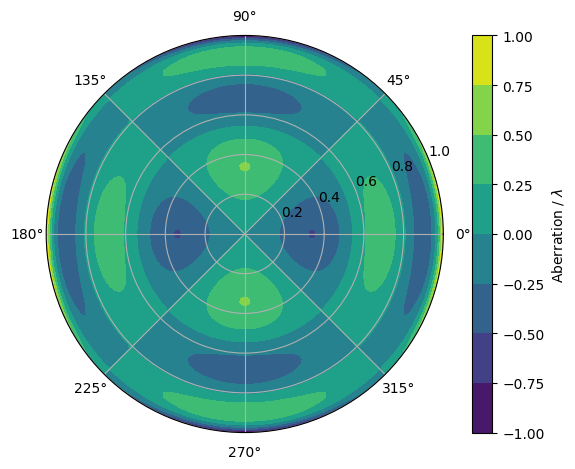

In [2]:
coeffs = np.zeros(36)
coeffs[31] = 1.0

wf = ais.Wavefront(1, coeffs, zern_order="SHS")

coeffs = np.zeros(36)
coeffs[31] = 1.0
wf2 = ais.Wavefront(1, coeffs, zern_order="WYANT")

wf.plot()
wf2.plot()

In [3]:
coeff_window = np.loadtxt("data/wavefront.txt")

Creating `Wavefront` objects and removing piston, tip and tilt from the data:

In [4]:
r_wf = 10.91e-3  # radius of the available wavefront data in m

wf = ais.Wavefront(r_wf, coeff_window, zern_order="WYANT")
wf2 = ais.Wavefront(r_wf, coeff_window, zern_order="SHS")
for n in [0, 1, 2, 35]:
    wf.coeff[n] = 0
    wf2.coeff[n] = 0

(<Figure size 640x480 with 2 Axes>, <PolarAxes: >)

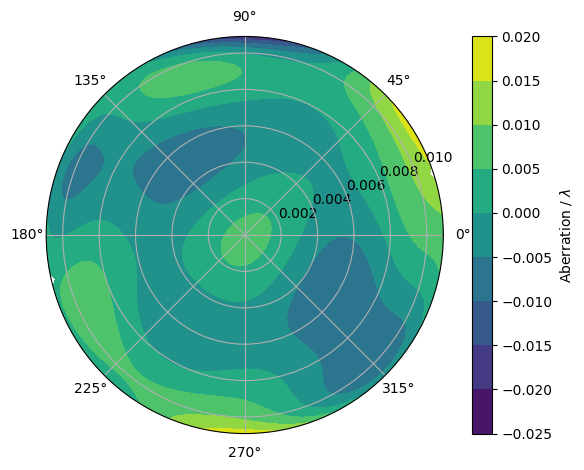

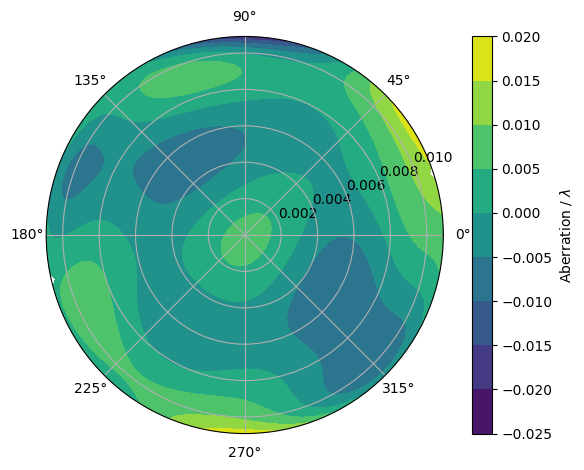

In [5]:
wf.plot()
wf2.plot()
# fig, ax = wf.plot_coeff()

### Creating an atomic ensemble

Due to the large number of parameters determining an atomic ensemble, dictionaries are used:

In [6]:
pos_params = {
    "mean_x": 0.0,
    "std_x": 3.0e-3,  # cloud radius in m
    "mean_y": 0.0,
    "std_y": 3.0e-3,  # cloud radius in m
    "mean_z": 0.0,
    "std_z": 0.0,  # ignore z dimension, its not relevant here
}
vel_params = {
    "mean_vx": 0.0,
    "std_vx": ais.convert.vel_from_temp(
        3.5e-6
    ),  # cloud velocity spread in m/s at tempearture of 3 uK
    "mean_vy": 0.0,
    "std_vy": ais.convert.vel_from_temp(
        3.5e-6
    ),  # cloud velocity spread in m/s at tempearture of 3 uK
    "mean_vz": 0.0,
    "std_vz": ais.convert.vel_from_temp(
        160e-9
    ),  # after velocity selection, velocity in z direction is 160 nK
}

atoms = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params, vel_params, int(1e5), state_kets=[0, 1], seed=1
)

Plotting the initial positions of the ensemble.

Text(0, 0.5, 'y / mm')

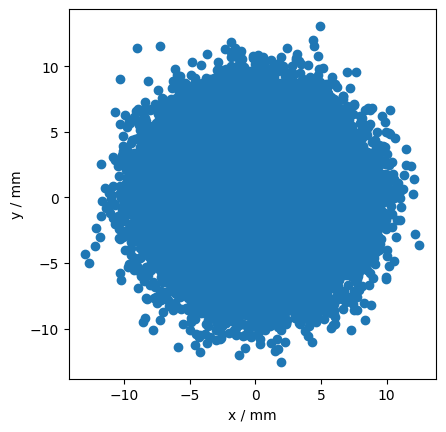

In [7]:
fig, ax = plt.subplots()
ax.scatter(1e3 * atoms.initial_position[:, 0], 1e3 * atoms.initial_position[:, 1])
ax.set_aspect("equal", "box")
ax.set_xlabel("x / mm")
ax.set_ylabel("y / mm")

### Setting up the detector

We want to calculate the dependency of the phase shift caused by wavefront aberrations on the detection area. For this reason, we set up a Detector with varying detection radius within a for-loop.

In [8]:
t_det = 778e-3  # time of the detection in s

### Simulation the bias in gravity from wavefront aberrations

For the simulation we need the objects created above and the timing of the interferometer sequence.

In [9]:
T = 260e-3  # interferometer time in s
t1 = 130e-3  # time of first pulse in s
t2 = t1 + T
t3 = t2 + T

In [10]:
awfs = []
r_dets = np.linspace(2e-3, 10e-3, 16)
for r_det in r_dets:
    # creating detector with new detection radius
    det = ais.PolarDetector(t_det, r_det=r_det)

    det_atoms = det.detected_atoms(atoms)

    # calculate the imprinted phase for each "test atom" at each pulse. This is the computationally heavy part
    phi1 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t1))
    phi2 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t2))
    phi3 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t3))

    # calculate a complex amplitude factor for the Mach-Zehnder sequence and calculate
    # the mean. Note that some atoms will have probed the wavefront outside of the
    # Raman beam radius and will thus have a NaN value in the phase.
    awfs.append(np.nanmean(np.exp(1j * (phi1 - 2 * phi2 + phi3))))

# factor two since the window is passed twice
g = 2 * ais.phase_error_to_grav(np.angle(awfs), T=260e-3, keff=1.610574779769e7)

We load the measured gravity data from a file and compare it to the simulation results.

In [11]:
data = json.load(open("data/experimental_data.json"))
r_det_data = np.array(data["r_det"])
grav = np.array(data["g"])
graverr = np.array(data["g_err"])

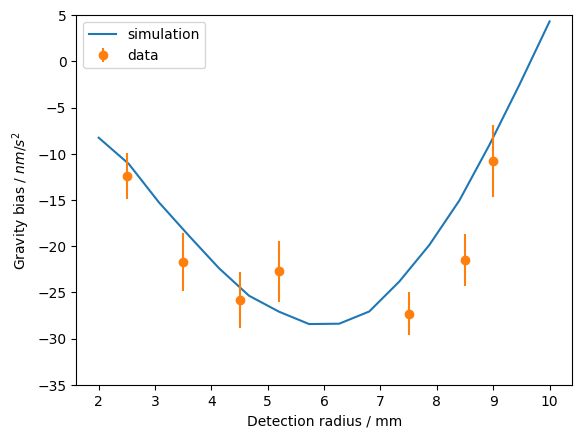

In [12]:
fig, ax = plt.subplots()
ax.plot(1e3 * r_dets, 1e9 * g, label="simulation")
ax.errorbar(1e3 * r_det_data, 1e9 * grav, yerr=1e9 * graverr, fmt="o", label="data")
ax.set_xlabel("Detection radius / mm")
ax.set_ylabel("Gravity bias / $nm/s^2$")
ax.set_ylim([-35, 5])
ax.legend()

Note that the original software used in the paper used a fixed position and velocity
grid rather than a Monte-Carlo approach, so some discrepancies are to be expected.